# Machine Learning and Quantum Alchemy: Day 3



Make sure to install `pyscf` first. If you use Google Colab, you can enter `!pip install pyscf`.

In [ ]:
!pip install pyscf

## Exercise 01

Use the following code to calculate the total energy of a dimer given a distance. Make sure to understand the basic steps in the code. Plot the bonding potential of CO and N$_{2}$ using `"STO-3G"` as `basis`.

In [ ]:
import pyscf.scf
import pyscf.gto

def dimer_energy(element1, element2, distance, basis):
  mol = pyscf.gto.M(atom=f"{element1} 0 0 0; {element2} 0 0 {distance}", basis=basis, verbose=0)
  calc = pyscf.scf.RHF(mol)

  return calc.kernel()

`element1` and `element2` are the element labels of the two atoms as string, e.g. `"N"` for a nitrogen. `distance` is the distance between the atom in Angstrom and `basis` defines the quality of the quantum chemistry calculation.

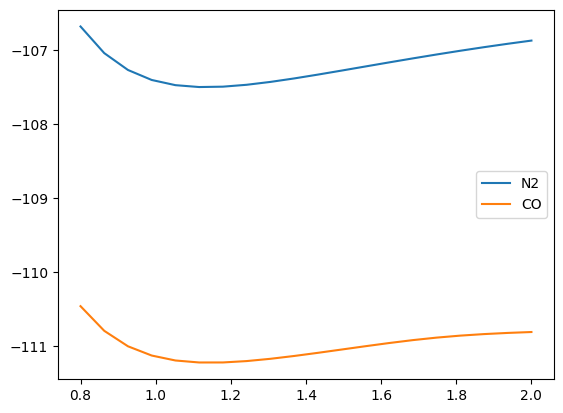

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs_1 = np.linspace(0.8, 2, 20)
ys_1 = [dimer_energy('N', 'N', _, 'STO_3G') for _ in xs_1]

xs_2 = np.linspace(0.8, 2, 20)
ys_2 = [dimer_energy('C', 'O', _, 'STO_3G') for _ in xs_2]

plt.plot(xs_1, ys_1, label = 'N2')
plt.plot(xs_2, ys_2, label = 'CO')

plt.legend()
plt.show()

## Exercise 02

A general strategy to calculate the derivative of a function is to use finite differences. From the definition of the (partial) derivative we can obtain a discretized simple expression for an approximate derivative:

$$
  \left.\frac{\partial f(x)}{\partial x}\right|_{x=x_0} := \lim_{\delta\rightarrow 0} \frac{f(x_0+\delta)-f(x_0)}{\delta}\Rightarrow \left.\frac{\partial f(x)}{\partial x}\right|_{x=x_0} \approx \frac{f(x_0+\delta)-f(x_0)}{\delta}
$$

Use the function `dimer_energy` from above to calculate the first derivative using finite differences at $x_0=1$ for N$_2$ and the basis `"STO-3G"`. Use different displacements $\delta$  and make a plot showing the derivative value as a function of $\delta$. What do you observe? How small can you make $\delta$? For comparison, the exact value is `-1.3979936186235125`.

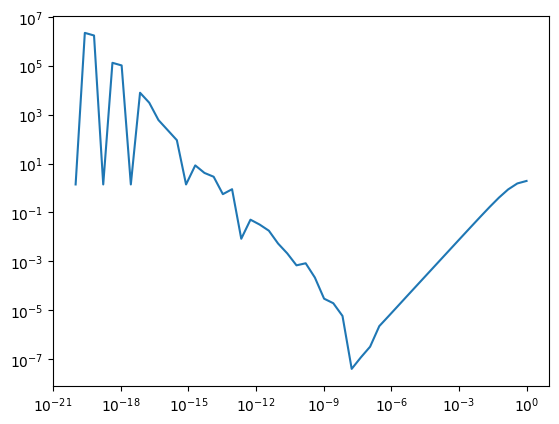

In [ ]:
def get_derivative(delta, center):
  a = dimer_energy('N', 'N', 1 + delta, 'STO_3G')

  return (a - center) / delta

center = dimer_energy('N', 'N', 1, 'STO_3G')
deltas = 10 ** np.linspace(-20, 0)
derivs = [get_derivative(delta, center) for delta in deltas]

refvalue = -1.3979936186235125

plt.loglog(deltas, np.abs(np.array(derivs) - refvalue))
plt.show()

## Exercise 03

Use the following code to calculate alchemical changes in a dimer. Plot the alchemical change from N$_{2}$ to CO and the reverse once for `basis="STO-3G"` and once for `basis="unc-def2-TZVP"`. Choose any reasonable distance for your plots. What do you observe?

In [ ]:
def dimer_energy(element1, element2, distance, alchemical_change, basis):
  mol = pyscf.gto.M(atom=f"{element1} 0 0 0; {element2} 0 0 {distance}", basis=basis, verbose=0)
  calc = pyscf.scf.RHF(mol)
  h1 = calc.get_hcore()

  s = 0

  for i, delta_Z in enumerate([1, -1]):
    mol.set_rinv_orig_(mol.atom_coords()[i])
    s -= delta_Z * alchemical_change * mol.intor("int1e_rinv")

  nn = (alchemical_change * np.diff(mol.atom_charges())[0] - alchemical_change**2)
  nn /= (distance / pyscf.data.nist.BOHR)

  calc.get_hcore = lambda *args, **kwargs: h1 + s

  return calc.kernel() + nn

`element1` and `element2` are the element labels of the two atoms as string, e.g. `"N"` for a nitrogen. `distance` is the distance between the atom in Angstrom and `basis` defines the quality of the quantum chemistry calculation. The now additional parameter `alchemical_change` modifies the nuclear charges of the involved atoms such that their sum remains the same but one is incremented by `alchemical_change` and one is decremented by the same amount.

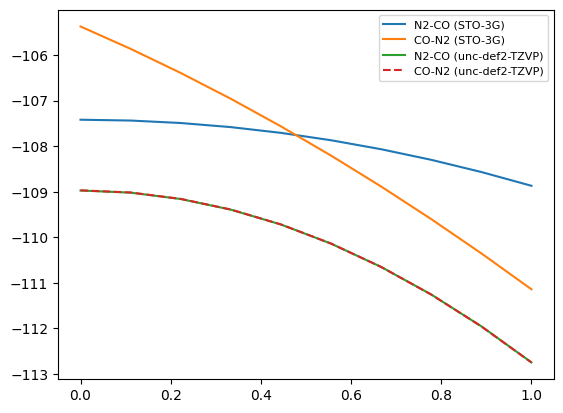

In [ ]:
xs = np.linspace(0, 1, 10)
basis = 'STO_3G'

N2_to_CO = [dimer_energy('N', 'N', 1, _, basis) for _ in xs]
CO_to_N2 = [dimer_energy('C', 'O', 1, _, basis) for _ in xs]

plt.plot(xs, N2_to_CO, label = 'N2-CO (STO-3G)')
plt.plot(xs, CO_to_N2[::-1], label = 'CO-N2 (STO-3G)')

basis = 'unc-def2-TZVP'

N2_to_CO = [dimer_energy('N', 'N', 1, _, basis) for _ in xs]
CO_to_N2 = [dimer_energy('C', 'O', 1, _, basis) for _ in xs]

plt.plot(xs, N2_to_CO, label = 'N2-CO (unc-def2-TZVP)', linestyle = '-')
plt.plot(xs, CO_to_N2[::-1], label = 'CO-N2 (unc-def2-TZVP)', linestyle = '--')

plt.legend(prop = {'size': 8})
plt.show()